## Imports

In [1]:

import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from EvaluationFunctions import performance_evaluation
import pipline

In [2]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
origin_dim = x_train.shape[1]

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## evaluation on Decision Trees

In [3]:
def get_model():
    return DecisionTreeClassifier()

### Performance evaluation - original data

Час навчання моделі - 19.29
Час затрачений для передбачення всіх x_test(10000) - 0.011 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 1107.54 KB
classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.87      0.85      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.88      0.87      0.88       982
           5       0.83      0.85      0.84       892
           6       0.89      0.88      0.89       958
           7       0.91      0.90      0.90      1028
           8       0.83      0.81      0.82       974
           9       0.85      0.86      0.86      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



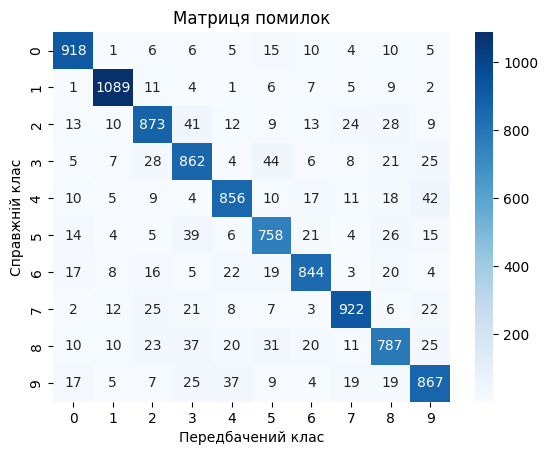

In [4]:
performance_evaluation(get_model(), x_train_flat, y_train, x_test_flat, y_test)

### Performance evaluation - reduced data - only AE

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0315
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0052
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.0044
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0041
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.0038
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0037
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.0036
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0035
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 0.0034
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.0033
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Час навчання моделі - 126.29
Час затрачений для передбачення всіх x_test(10000) - 0.011 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 923.88 KB
classification report:
    

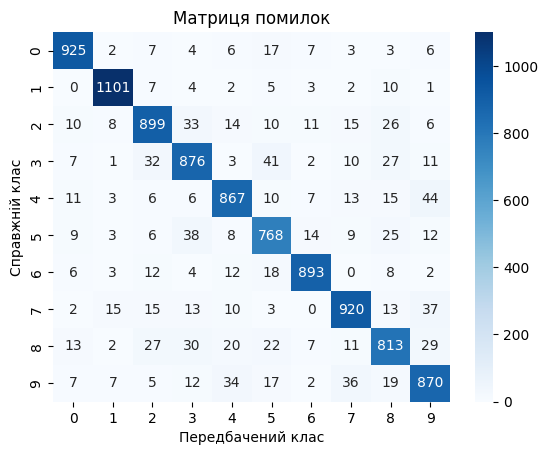

In [5]:
myPipe = pipline.myReducePipline()
x_train_ae,x_test_ae = myPipe.fit_ae_model(x_train,x_test)
performance_evaluation(get_model(), x_train_ae, y_train, x_test_ae, y_test)

### Performance evaluation - reduced data - only SVD

Час навчання моделі - 17.03
Час затрачений для передбачення всіх x_test(10000) - 0.002 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 1339.01 KB
classification report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       980
           1       0.95      0.97      0.96      1135
           2       0.84      0.86      0.85      1032
           3       0.81      0.83      0.82      1010
           4       0.82      0.80      0.81       982
           5       0.80      0.78      0.79       892
           6       0.91      0.88      0.90       958
           7       0.86      0.85      0.85      1028
           8       0.75      0.75      0.75       974
           9       0.77      0.79      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



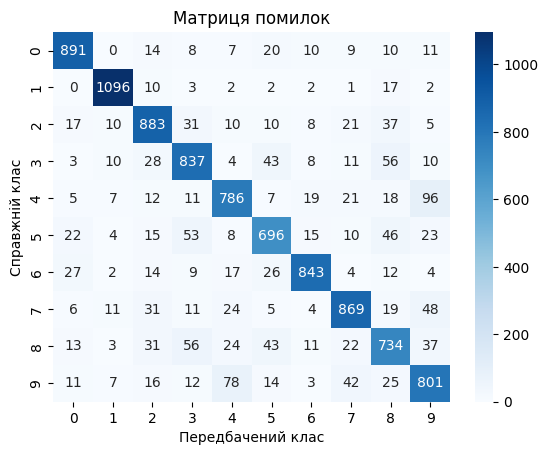

In [6]:
myPipeSvd = pipline.myReducePipline()
x_train_svd,x_test_svd = myPipeSvd.fit_svd_model(x_train_flat,x_test_flat)
performance_evaluation(get_model(), x_train_svd, y_train, x_test_svd, y_test)

### Performance evaluation - reduced data

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0322
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0052
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0044
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0041
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0038
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0037
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0036
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0035
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0034
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0034
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
AE create + train time:  209.50997304916382  sec
SVD create + train time: 1.3807706832885742  sec
Час навчання моделі - 21.74
Час затрачений для передбачення всіх x_test(10000) - 0.004 сек
Розмір моделі в 

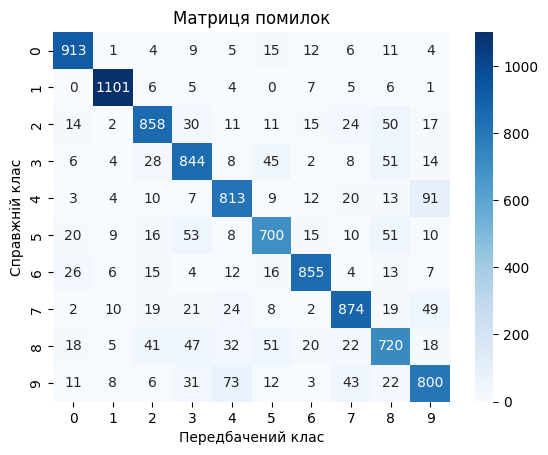

In [7]:
myPipe = pipline.myReducePipline()
x_train_reduced,x_test_reduced = myPipe.run_pipeline(x_train,x_test)
performance_evaluation(get_model(), x_train_reduced, y_train, x_test_reduced, y_test)

### print all data size

In [8]:
x1 = sys.getsizeof(x_train)
x2 = sys.getsizeof(x_train_ae)
x3 = sys.getsizeof(x_train_reduced)
print(f"Розмір оригінальних даних - { x1 } байт")
print(f"Розмір після автоенкодера - { x2 } байт ({x2/x1})")
print(f"Розмір редукованих даних  - { x3 } байт ({x3/x1})")

Розмір оригінальних даних       - 188160144 байт
Розмір після автоенкодера       - 128 байт (6.80271588227526e-07)
Розмір після автоенкодера + SVD - 19200128 байт (0.10204141850571713)


## visualisation

In [9]:
x_ae = x_train_ae.reshape(len(x_train_ae), origin_dim, -1)
x_ae.shape

(60000, 28, 28)

In [10]:
X_recovered = myPipeSvd.get_svd_inverse_transform(x_train_svd)
x_svd = X_recovered.reshape(len(X_recovered), origin_dim, -1)
x_svd.shape

(60000, 28, 28)

In [11]:
import math
x_svd_lat = x_train_svd.reshape(len(x_train_svd), int(math.sqrt(myPipeSvd.lat_dim_svd)), -1)
x_svd_lat.shape

(60000, 8, 10)

In [12]:
def plot_classes(x, y, title=''):
    unique_classes = np.unique(y)
    nrows, ncols = 1, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]

        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]

        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    print(title)
    plt.show()

origin


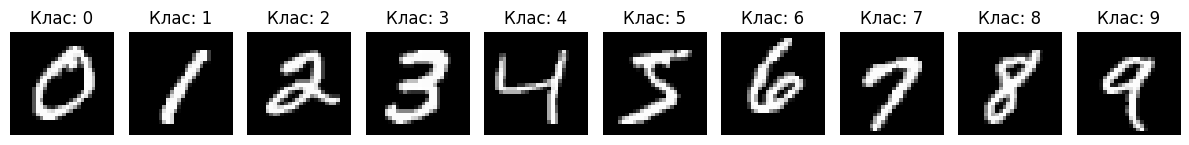

after AutoEncoder


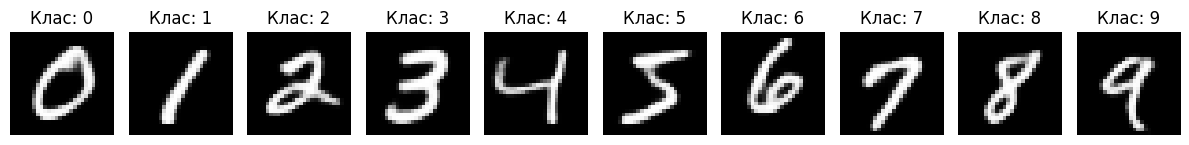

after AE+SVD (inversed)


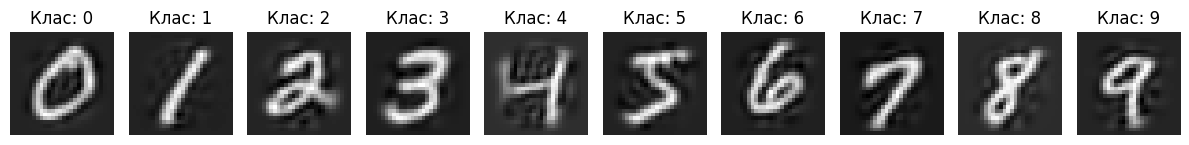

after AE+SVD (reduced)


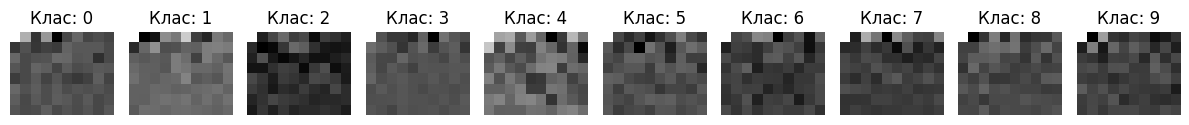

In [13]:
plot_classes(x_train,y_train, "origin")
plot_classes(x_ae,y_train, "after AutoEncoder")
plot_classes(x_svd,y_train, "after AE+SVD (inversed)") # after svd inverse
plot_classes(x_svd_lat,y_train, "after AE+SVD (reduced)") # clean svd